In [13]:
# Data Preview: list all columns and show first 5 rows
import pandas as pd

raw_data_path = '../data/Synthetic_Data_For_Students.csv'  # adjust path if needed
df_raw = pd.read_csv(raw_data_path)
pd.set_option('display.max_columns', None)  # show every column
print("Columns in dataset:\n", df_raw.columns.tolist(), "\n")
df_raw.head()


Columns in dataset:
 ['SettlementValue', 'AccidentType', 'Injury_Prognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash', 'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date', 'Vehicle Age', 'Driver Age', 'Number of Passengers', 'Accident Description', 'Injury Description', 'Police Report Filed', 'Witness Present', 'Gender'] 



,SettlementValue,AccidentType,Injury_Prognosis,SpecialHealthExpenses,SpecialReduction,SpecialOverage,GeneralRest,SpecialAdditionalInjury,SpecialEarningsLoss,SpecialUsageLoss,SpecialMedications,SpecialAssetDamage,SpecialRehabilitation,SpecialFixes,GeneralFixed,GeneralUplift,SpecialLoanerVehicle,SpecialTripCosts,SpecialJourneyExpenses,SpecialTherapy,Exceptional_Circumstances,Minor_Psychological_Injury,Dominant injury,Whiplash,Vehicle Type,Weather Conditions,Accident Date,Claim Date,Vehicle Age,Driver Age,Number of Passengers,Accident Description,Injury Description,Police Report Filed,Witness Present,Gender
0,520.0,Rear end,E. 5 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Arms,Yes,Motorcycle,Rainy,2023-11-10 11:22:24.508901,2024-06-11 11:22:24.508901,13.0,33.0,4.0,Side collision at an intersection.,Whiplash and minor bruises.,Yes,Yes,Male
1,870.0,Rear end,B. 2 months,0.0,0.0,0.0,520.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,260.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Multiple,Yes,Motorcycle,Snowy,2023-06-25 00:55:01.140228,2024-01-09 00:55:01.140228,4.0,45.0,2.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
2,2140.0,Other side pulled out of side road,G. 7 months,0.0,0.0,0.0,1400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,840.0,0.0,0.0,0.0,0.0,0.0,No,No,Legs,Yes,Motorcycle,Sunny,2020-02-23 17:43:47.805561,2020-03-01 17:43:47.805561,9.0,45.0,4.0,Lost control on a snowy road.,Whiplash and minor bruises.,Yes,No,Female
3,520.0,Rear end - Clt pushed into next vehicle,D. 4 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Arms,Yes,Truck,Rainy,2021-10-02 04:36:32.118423,2021-10-13 04:36:32.118423,5.0,62.0,1.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
4,260.0,Rear end,C. 3 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Arms,No,Motorcycle,Rainy,2023-04-02 05:13:07.117423,2023-04-14 05:13:07.117423,9.0,78.0,1.0,Lost control on a snowy road.,Concussion and bruised ribs.,Yes,Yes,Other


In [14]:
# If SHAP isn't available yet, install it
import sys
!{sys.executable} -m pip install shap

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\aasri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Master Notebook: Predicting Settlement Values

**Purpose:**  
Walk through the full ML workflow: data loading, cleaning, train/test split, preprocessing, model tuning, subgroup fairness, explainability, and an interactive demo.

**Notebook outline:**
1. Load & Inspect Data  
2. Identify & Clean Target  
3. Train/Test Split  
4. Preprocessing Pipeline  
5. Model Training & Hyperparameter Tuning  
6. Fairness Analysis (DriverAge × Gender)  
7. Explainability with SHAP  
8. Interactive Prediction Demo  


In [15]:
# 1. Load & Inspect Data
import pandas as pd
import numpy as np

raw_data_path = '../data/Synthetic_Data_For_Students.csv'  # adjust if needed
df_raw = pd.read_csv(raw_data_path)
df_raw.columns = df_raw.columns.str.strip()               # strip whitespace

# Rename for simplicity
df_raw.rename(columns={'Driver Age': 'DriverAge'}, inplace=True)

print("🎯 Columns in dataset:", df_raw.columns.tolist())


🎯 Columns in dataset: ['SettlementValue', 'AccidentType', 'Injury_Prognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash', 'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date', 'Vehicle Age', 'DriverAge', 'Number of Passengers', 'Accident Description', 'Injury Description', 'Police Report Filed', 'Witness Present', 'Gender']


## 2. Identify & Clean Target

We expect **SettlementValue** to be our target. Drop any rows where it’s missing.


In [16]:
# 2a. Validate & set target
target_col = 'SettlementValue'
if target_col not in df_raw.columns:
    raise KeyError(f"Column '{target_col}' not found in CSV.")
print(f"✅ Using '{target_col}' as the target.")

# 2b. Drop missing-target rows
before = len(df_raw)
df_raw = df_raw.dropna(subset=[target_col]).reset_index(drop=True)
print(f"🚮 Dropped {before - len(df_raw)} rows → new shape: {df_raw.shape}")


✅ Using 'SettlementValue' as the target.
🚮 Dropped 106 rows → new shape: (4894, 36)


## 3. Train/Test Split

Use a single 80/20 split (random_state=42) so all downstream steps reference the same partitions.


In [17]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    df_raw.index, test_size=0.2, random_state=42
)

df_train = df_raw.loc[train_idx].reset_index(drop=True)
df_test  = df_raw.loc[test_idx].reset_index(drop=True)

print(f"🚂 Train size: {df_train.shape},  🛳 Test size: {df_test.shape}")


🚂 Train size: (3915, 36),  🛳 Test size: (979, 36)


## 4. Preprocessing Pipeline

We’ll impute & scale numeric features, and impute & one-hot encode categorical ones.


In [18]:
import numpy as np
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4a. Identify feature columns from the training split
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(target_col)
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 4b. Build the ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# 4c. Fit transformer on train, transform train & test
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col].values
X_test  = df_test.drop(columns=[target_col])
y_test  = df_test[target_col].values

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Before density conversion:",
      type(X_train_proc), X_train_proc.shape,
      type(X_test_proc),  X_test_proc.shape)

# 4d. Convert any sparse matrices to dense arrays
if sp.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()
if sp.issparse(X_test_proc):
    X_test_proc  = X_test_proc.toarray()

print("After density conversion:",
      type(X_train_proc), X_train_proc.shape,
      type(X_test_proc),  X_test_proc.shape)


Before density conversion: <class 'scipy.sparse._csr.csr_matrix'> (3915, 6620) <class 'scipy.sparse._csr.csr_matrix'> (979, 6620)
After density conversion: <class 'numpy.ndarray'> (3915, 6620) <class 'numpy.ndarray'> (979, 6620)


## 5. Model Training & Hyperparameter Tuning

Train three regressors with 5-fold GridSearchCV, optimizing MAPE:
- Decision Tree  
- XGBoost (fallback to GradientBoosting)  
- Random Forest  


In [19]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# XGBoost fallback
try:
    from xgboost import XGBRegressor
    BoostReg, boost_name = XGBRegressor, 'XGBoost'
except ModuleNotFoundError:
    from sklearn.ensemble import GradientBoostingRegressor
    BoostReg, boost_name = GradientBoostingRegressor, 'GradBoost'
print(f"🔧 Tuning with {boost_name}")

# Optionally downsample training for tuning
tune_frac = 0.5
idx_sub = np.random.RandomState(42).choice(
    X_train_proc.shape[0],
    size=int(X_train_proc.shape[0] * tune_frac),
    replace=False
)
X_tune, y_tune = X_train_proc[idx_sub], y_train[idx_sub]

# Define parameter distributions
param_dists = {
    'DecisionTree': {
        'max_depth': [3, 5, 7, None]
    },
    boost_name: {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None]
    }
}

# Configure models
candidates = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    boost_name:    BoostReg(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

best_models = {}
results = []

# Randomized search loop
for name, estimator in candidates.items():
    dist = param_dists[name]
    print(f"\n🔎 Randomized tuning {name}...")
    rs = RandomizedSearchCV(
        estimator, dist,
        n_iter=15,      # try 15 random combos
        scoring='neg_mean_absolute_percentage_error',
        cv=3,           # 3-fold cross-validation
        random_state=42,
        n_jobs=-1
    )
    rs.fit(X_tune, y_tune)
    best = rs.best_estimator_
    
    # Refit best model on the *full* training set
    best.fit(X_train_proc, y_train)
    
    # Evaluate on the full test set
    preds = best.predict(X_test_proc)
    mape  = mean_absolute_percentage_error(y_test, preds)
    
    best_models[name] = best
    results.append((name, mape, rs.best_params_))
    print(f"✅ {name}: Test MAPE={mape:.4f}; Tuned params={rs.best_params_}")

# Show summary table
import pandas as pd
df_results = pd.DataFrame(results, columns=['Model','Test MAPE','Tuned Params'])
df_results.sort_values('Test MAPE', inplace=True)
df_results


🔧 Tuning with GradBoost

🔎 Randomized tuning DecisionTree...
✅ DecisionTree: Test MAPE=0.0730; Tuned params={'max_depth': None}

🔎 Randomized tuning GradBoost...
✅ GradBoost: Test MAPE=0.1128; Tuned params={'n_estimators': 200, 'max_depth': 7}

🔎 Randomized tuning RandomForest...
✅ RandomForest: Test MAPE=0.0918; Tuned params={'n_estimators': 200, 'max_depth': None}


,Model,Test MAPE,Tuned Params
0,DecisionTree,0.072976,{'max_depth': None}
2,RandomForest,0.091783,"{'n_estimators': 200, 'max_depth': None}"
1,GradBoost,0.112767,"{'n_estimators': 200, 'max_depth': 7}"


## 6. Fairness Analysis (DriverAge × Gender)

Assess the chosen “Boost” model’s MAPE across DriverAge × Gender subgroups.


In [20]:
from sklearn.metrics import mean_absolute_percentage_error

# 6a. Pick the Boost model
boost_keys = [k for k in best_models if 'Boost' in k]
model_key  = boost_keys[0] if boost_keys else next(iter(best_models))
print(f"🔍 Evaluating subgroup MAPE with: {model_key}")

# 6b. Attach predictions to df_test
df_test = df_test.copy()
df_test['prediction'] = best_models[model_key].predict(X_test_proc)

# 6c. Compute & print MAPE per subgroup
for (age_val, gender_val), grp in df_test.groupby(['DriverAge','Gender']):
    mape = mean_absolute_percentage_error(grp[target_col], grp['prediction'])
    print(f"{model_key} MAPE (DriverAge={age_val}, Gender={gender_val}): {mape:.4f}")


🔍 Evaluating subgroup MAPE with: GradBoost
GradBoost MAPE (DriverAge=18.0, Gender=Female): 0.1241
GradBoost MAPE (DriverAge=18.0, Gender=Other): 0.0469
GradBoost MAPE (DriverAge=19.0, Gender=Female): 0.0273
GradBoost MAPE (DriverAge=19.0, Gender=Male): 0.1151
GradBoost MAPE (DriverAge=19.0, Gender=Other): 0.0654
GradBoost MAPE (DriverAge=20.0, Gender=Female): 0.1334
GradBoost MAPE (DriverAge=20.0, Gender=Male): 0.0671
GradBoost MAPE (DriverAge=20.0, Gender=Other): 0.1337
GradBoost MAPE (DriverAge=21.0, Gender=Female): 0.0493
GradBoost MAPE (DriverAge=21.0, Gender=Male): 0.0541
GradBoost MAPE (DriverAge=21.0, Gender=Other): 0.0474
GradBoost MAPE (DriverAge=22.0, Gender=Female): 0.1350
GradBoost MAPE (DriverAge=22.0, Gender=Male): 0.1698
GradBoost MAPE (DriverAge=22.0, Gender=Other): 0.0282
GradBoost MAPE (DriverAge=23.0, Gender=Female): 0.0798
GradBoost MAPE (DriverAge=23.0, Gender=Male): 0.1165
GradBoost MAPE (DriverAge=23.0, Gender=Other): 0.0376
GradBoost MAPE (DriverAge=24.0, Gender

## 7. Explainability with SHAP

Generate a SHAP summary plot for global feature importance on the test set.


🔎 Global feature importance (test set):


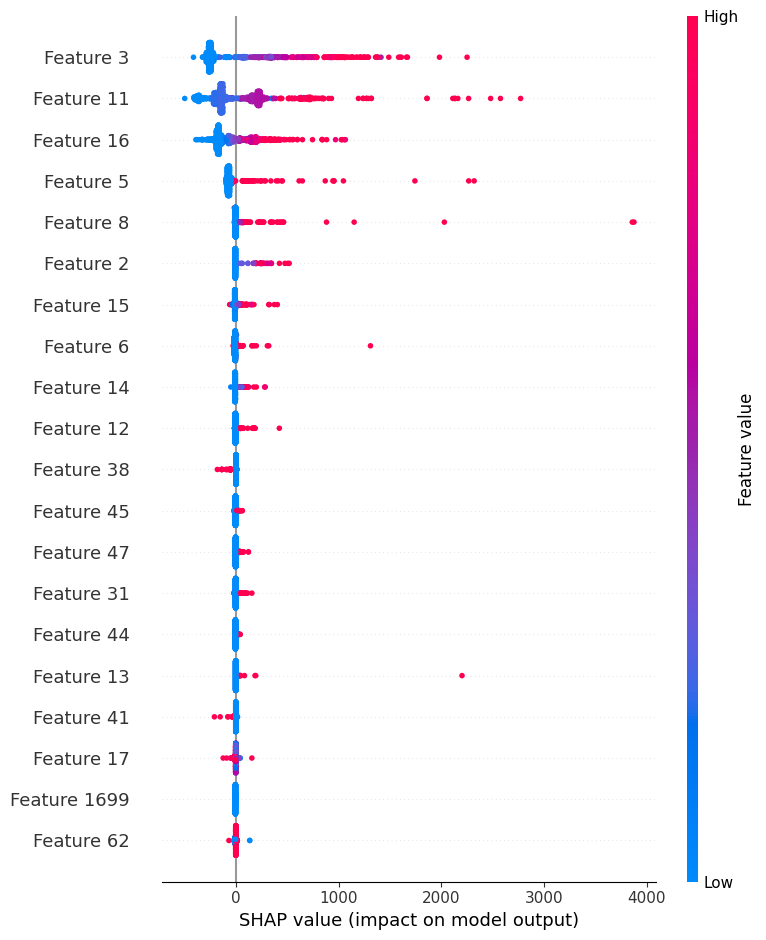

In [21]:
import shap
shap.initjs()

# 1. Initialize explainer on your chosen Boost model
explainer   = shap.Explainer(best_models[model_key], X_train_proc)

# 2. Global summary on the now‐dense test set
shap_values = explainer(X_test_proc)
print("🔎 Global feature importance (test set):")
shap.summary_plot(shap_values, features=X_test_proc)

# 3. Enhanced predict_and_explain() with waterfall plot
def predict_and_explain(record: dict):
    df_rec = pd.DataFrame([record])
    X_rec  = preprocessor.transform(df_rec)
    # also convert this one to dense if needed
    if sp.issparse(X_rec):
        X_rec = X_rec.toarray()
    pred   = best_models[model_key].predict(X_rec)[0]
    print(f"🔮 Prediction: {pred:.2f}\n")
    shap_vals_rec = explainer(X_rec)
    print("📊 Local explanation (waterfall):")
    shap.plots.waterfall(shap_vals_rec[0])
    return pred, shap_vals_rec


Top 10 features by SHAP importance:
  3: GeneralRest (mean |SHAP| = 341.31)
 11: GeneralFixed (mean |SHAP| = 261.90)
 16: SpecialTherapy (mean |SHAP| = 165.12)
  5: SpecialEarningsLoss (mean |SHAP| = 85.52)
  8: SpecialAssetDamage (mean |SHAP| = 24.51)
  2: SpecialOverage (mean |SHAP| = 14.67)
 15: SpecialJourneyExpenses (mean |SHAP| = 14.55)
  6: SpecialUsageLoss (mean |SHAP| = 10.45)
 14: SpecialTripCosts (mean |SHAP| = 9.13)
 12: GeneralUplift (mean |SHAP| = 7.75)


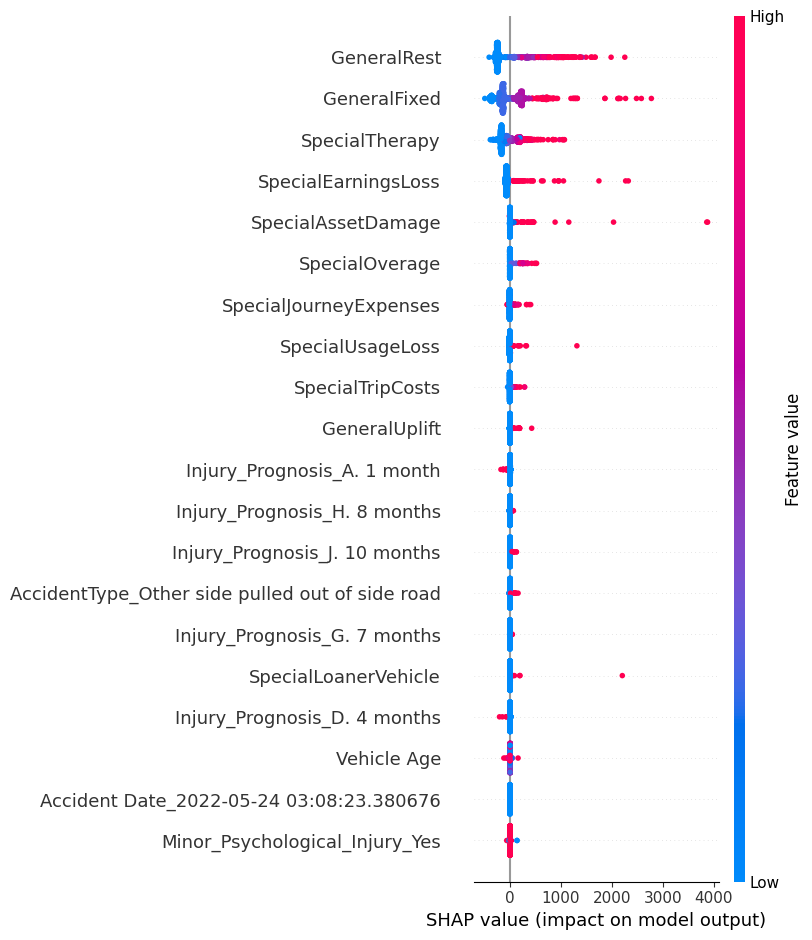

In [22]:
# — Map preprocessed feature columns back to human-readable names —

# 1. Numeric feature names (already defined)
num_feats = num_cols

# 2. OneHotEncoder feature names for the categoricals
cat_feats = (
    preprocessor
      .named_transformers_['cat']          # the "cat" transformer
      .named_steps['encoder']              # step name is 'encoder', not 'encode'
      .get_feature_names_out(cat_cols)     # pass in original cat column names
      .tolist()
)

# 3. Combine
feature_names = num_feats + cat_feats

# 4. Sanity check
assert len(feature_names) == X_train_proc.shape[1], (
    f"Expected {X_train_proc.shape[1]} names, got {len(feature_names)}"
)

# 5. Show top 10 by mean absolute SHAP
import numpy as np
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(-mean_abs_shap)[:10]

print("Top 10 features by SHAP importance:")
for i in top_idx:
    print(f"{i:3d}: {feature_names[i]} (mean |SHAP| = {mean_abs_shap[i]:.2f})")

# 6. (Optional) Re-plot summary with labels
shap.summary_plot(
    shap_values, 
    features=X_test_proc, 
    feature_names=feature_names
)


## 8. Interactive Prediction Demo

Define a helper to predict on a custom record and display its SHAP values.


In [25]:
def predict_and_explain(record: dict):
    """
    record: dict of original feature names → values (e.g. {'DriverAge': 45, 'Gender':'Male', ...})
    Returns the prediction and displays SHAP explanation.
    """
    df_rec = pd.DataFrame([record])
    X_rec  = preprocessor.transform(df_rec)
    pred   = best_models[model_key].predict(X_rec)[0]
    shap_v = explainer(X_rec)
    print(f"🔮 Prediction: {pred:.2f}")
    display(shap_v)
    return pred, shap_v
